# Step 1.3 - Add population density to the Copenhagen carall Network
## Project: Growing Urban Bicycle Networks

This notebook loads population density data from Copenhagen in 2019, and applies a fraction of this to the nearest edges in the carall network. a population density attribute 'pop_den_attr' is added to the network, represented as edgelength multiplied with the fraction of the population density for the given street. For edges that are not assigned this attribute, the average edgelength multiplied with the average population density in the network, is assigned

pop_den_attr_unassigned = 7.193810421653459

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2021-03-10

## Preliminaries

### Parameters

In [111]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [112]:
%run -i path.py
#%run -i setup.py
%run -i setupCPH.py
import pandas as pd
from sklearn import preprocessing
%load_ext watermark
%watermark -n -v -m -g -iv
import statistics

Loaded PATH.

Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: b795eaefba9eb6349c319ca07997ebd31e033f57

numpy     : 1.23.3
pandas    : 1.4.4
geojson   : 2.5.0
igraph    : 0.9.1
networkx  : 2.8.6
geopandas : 0.11.1
csv       : 1.0
fiona     : 1.8.21
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
watermark : 2.3.1
sklearn   : 1.1.2
shapely   : 1.8.4
matplotlib: 3.6.0
pyproj    : 3.4.0
osgeo     : 3.2.1
osmnx     : 0.16.2



### Functions

In [113]:
%run -i functions.py

Loaded functions.



## Load carall graph

In [114]:
G_carall = ox.load_graphml('../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml')

## Load population density data, convert to fractions and normalise

In [115]:
pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ.csv")
#pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ_small.csv")

#convert to fraction. All pop densities are added 1 to avoid division by zero (if zero density).
pop_den_df['pop_den_attr']= pop_den_df['Z']
for i in range(len(pop_den_df['Z'])):
    pop_den_df['pop_den_attr'].iloc[i] = 1.0/float(pop_den_df['pop_den_attr'].iloc[i]+1)
    #Normalise population density
x = pop_den_df.drop(pop_den_df.columns[[0,1,2]], axis=1) #returns a numpy array of only bikecounts
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
pop_den_norm_df = pd.DataFrame(x_scaled)

for i in range(len(pop_den_df)):
    pop_den_df['pop_den_attr'].iloc[i] = pop_den_norm_df.iloc[i]

pop_den_df.rename(columns = {'X':'long', 'Y':'lat','Z':'pop_den'}, inplace = True)

## Add 'pop_den_attr' to carall graph

In [116]:
#mean_pop_den_attr = pop_den_df['pop_den_attr'].mean()

#with open('../../bikenwgrowth_external/data/copenhagen/bikedata/max_pop_den_attr.pkl', 'wb') as y:
#    pickle.dump(mean_pop_den_attr, y)

#edges_len_dict = nx.get_edge_attributes(G_carall, 'length')
#edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])

#Initially set to 0, as we otherwise would get the average population density for whole denmark
pop_den_attr_unassigned = 0.0

nx.set_edge_attributes(G_carall, pop_den_attr_unassigned, 'pop_den_attr')


#With haversine, should have less edges in plot
for i in range(len(pop_den_df)):
    n = ox.distance.get_nearest_node(G_carall, [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
    if haversine([pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long], (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
        ne = ox.distance.get_nearest_edge(G_carall, [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
        pcount = pop_den_df.iloc[i].pop_den_attr
        nx.set_edge_attributes(G_carall, {ne: {"pop_den_attr": pcount }})
    

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
pop_len_attr_dict = nx.get_edge_attributes(G_carall, "pop_den_attr")



/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


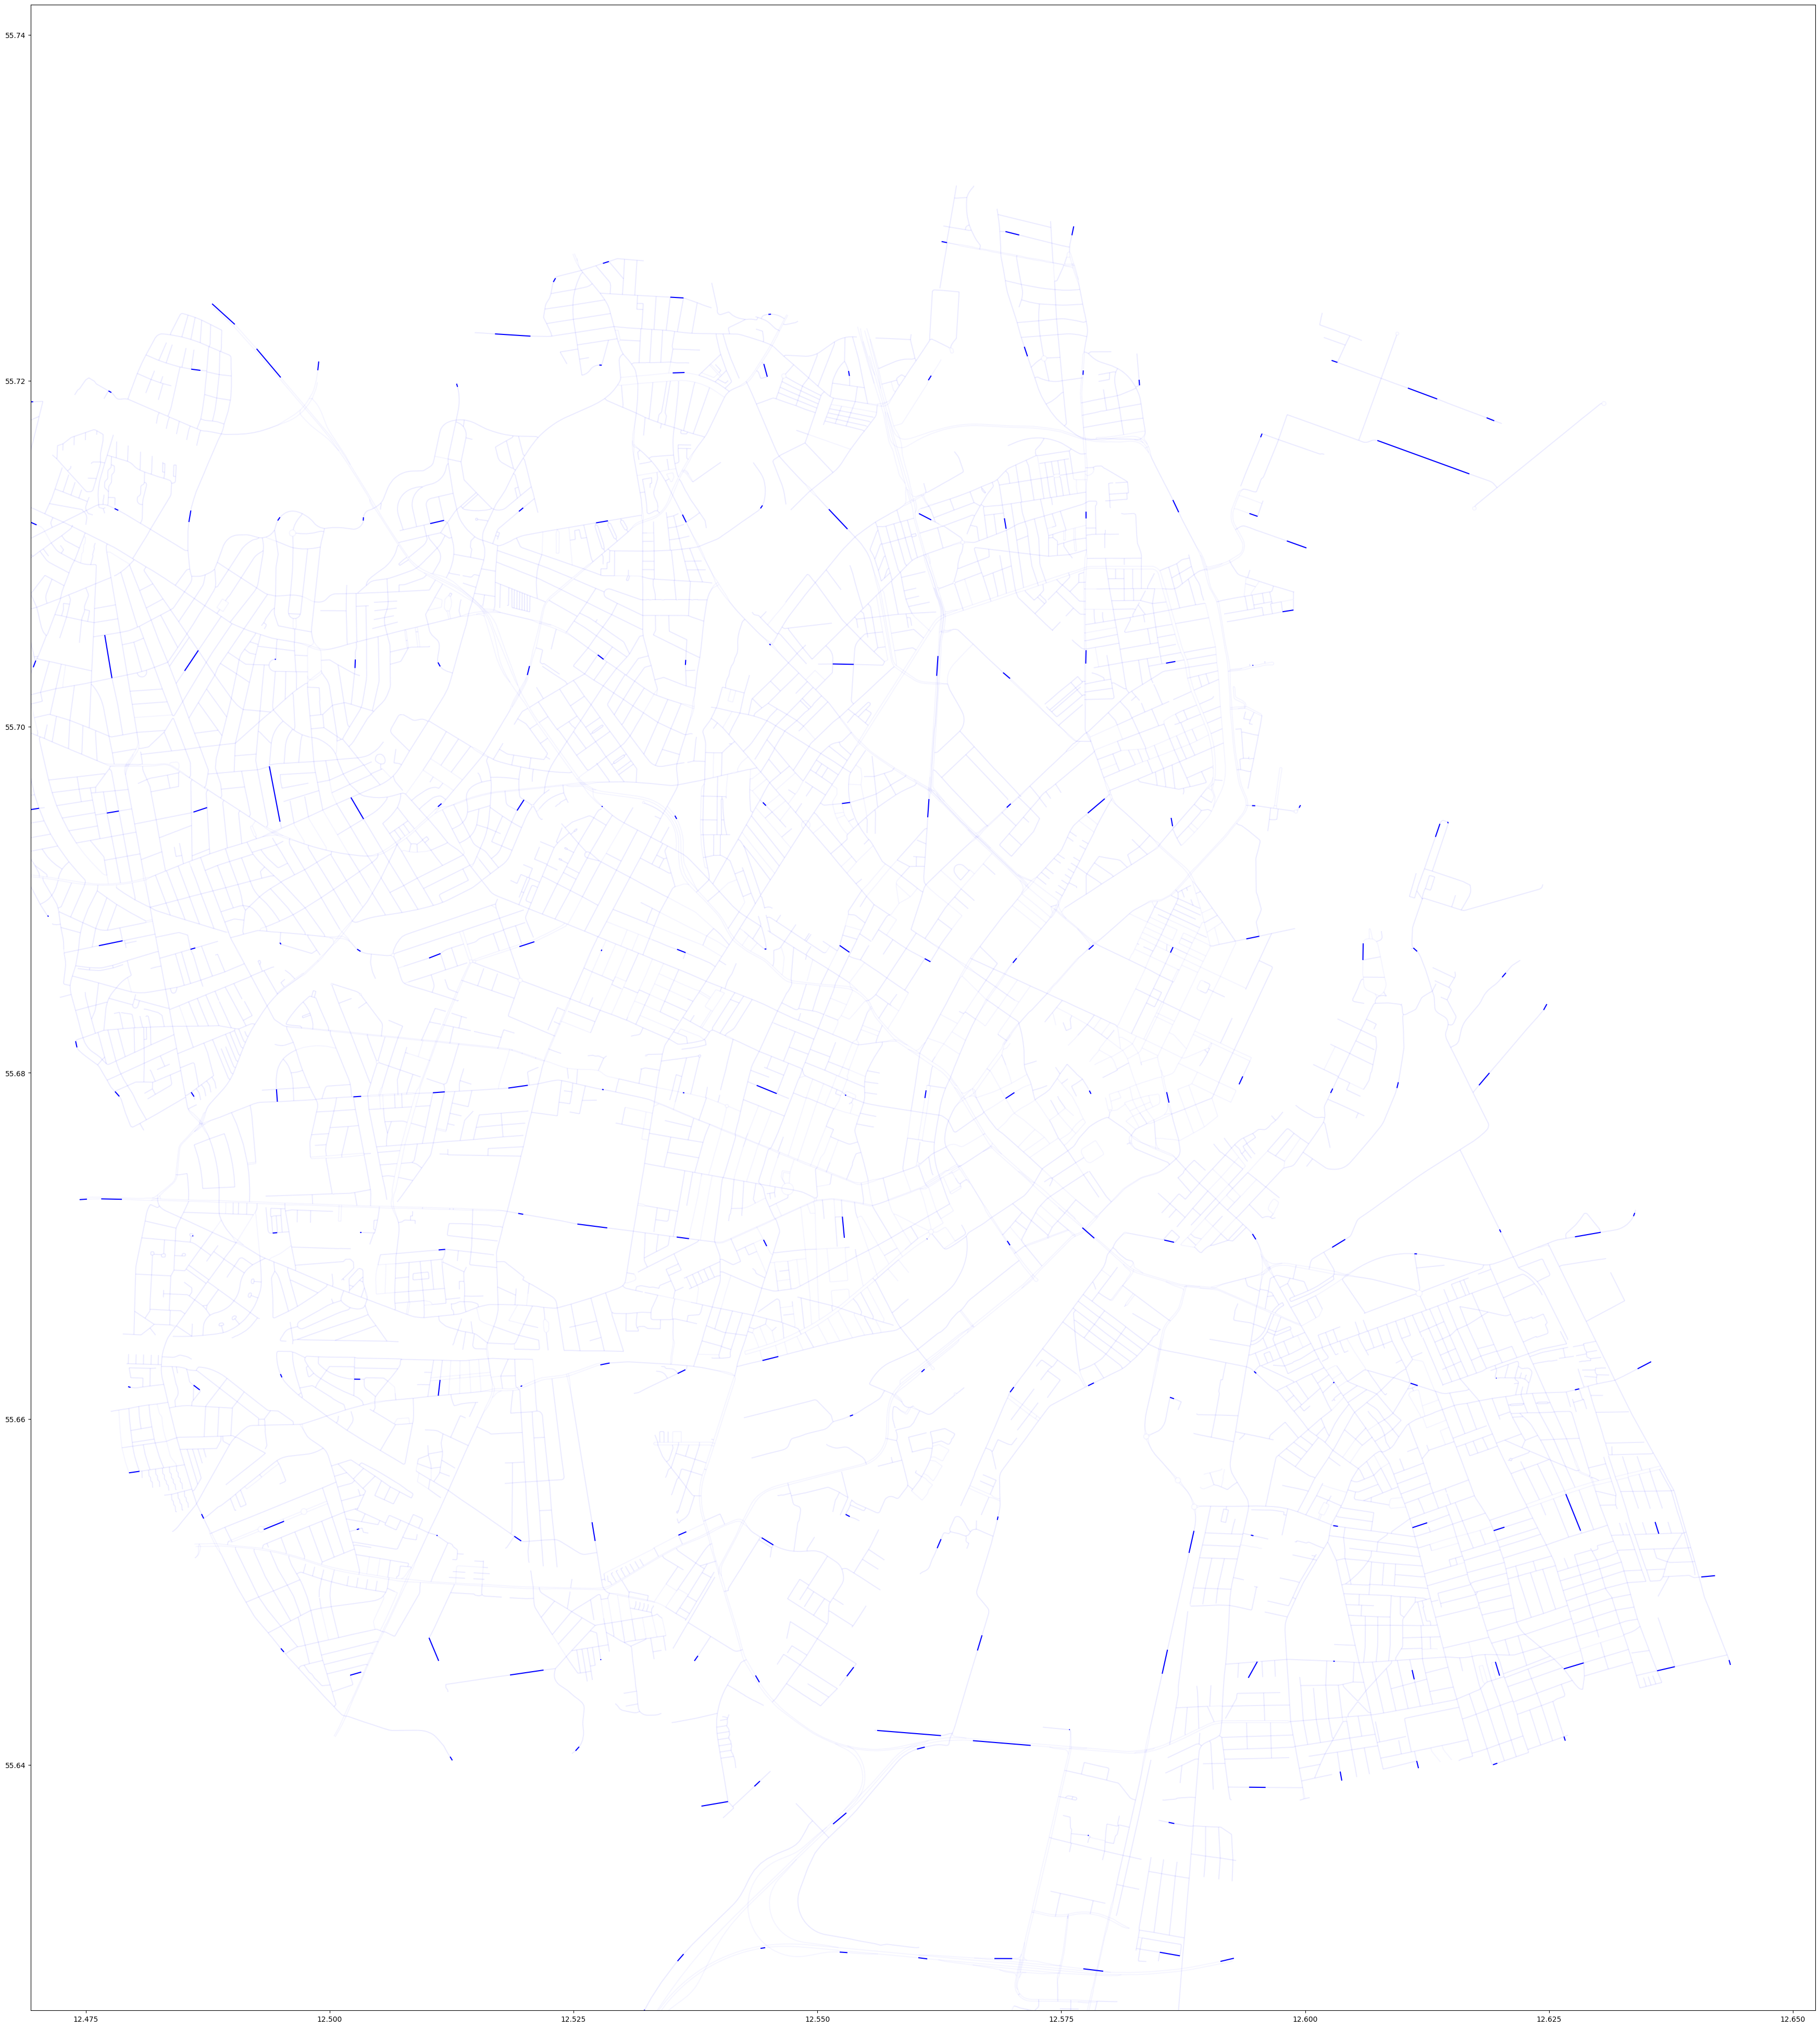

In [117]:
lanes = ox.graph_to_gdfs(G_carall, nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (pop_len_attr_dict[k]) == pop_den_attr_unassigned else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

In [118]:
#to get the mean population density from copenhagen edges we calculate the mean of assigned edges and
#assign each edge their length multiplied by the fraction of population density
pop_den_attr_unassigned = statistics.mean([x for x in list(pop_len_attr_dict.values()) if x!= pop_den_attr_unassigned])

In [122]:
pop_den_attr_unassigned

0.10040273320068874

In [123]:
edges_len_dict = nx.get_edge_attributes(G_carall, 'length')
edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])

for e in G_carall.edges():
    a,b=e
    popden = G_carall.get_edge_data(a,b,0)['pop_den_attr']
    edgelength = G_carall.get_edge_data(a,b,0)['length']
    if popden ==0.0:
        attr = pop_den_attr_unassigned * edges_len_mean
    else:
        attr = popden * edgelength
    nx.set_edge_attributes(G_carall, {(a,b,0): {"pop_den_attr": attr }})




In [125]:
dd = pop_den_attr_unassigned * edges_len_mean

In [126]:
pop_len_attr_dict = nx.get_edge_attributes(G_carall, "pop_den_attr")

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


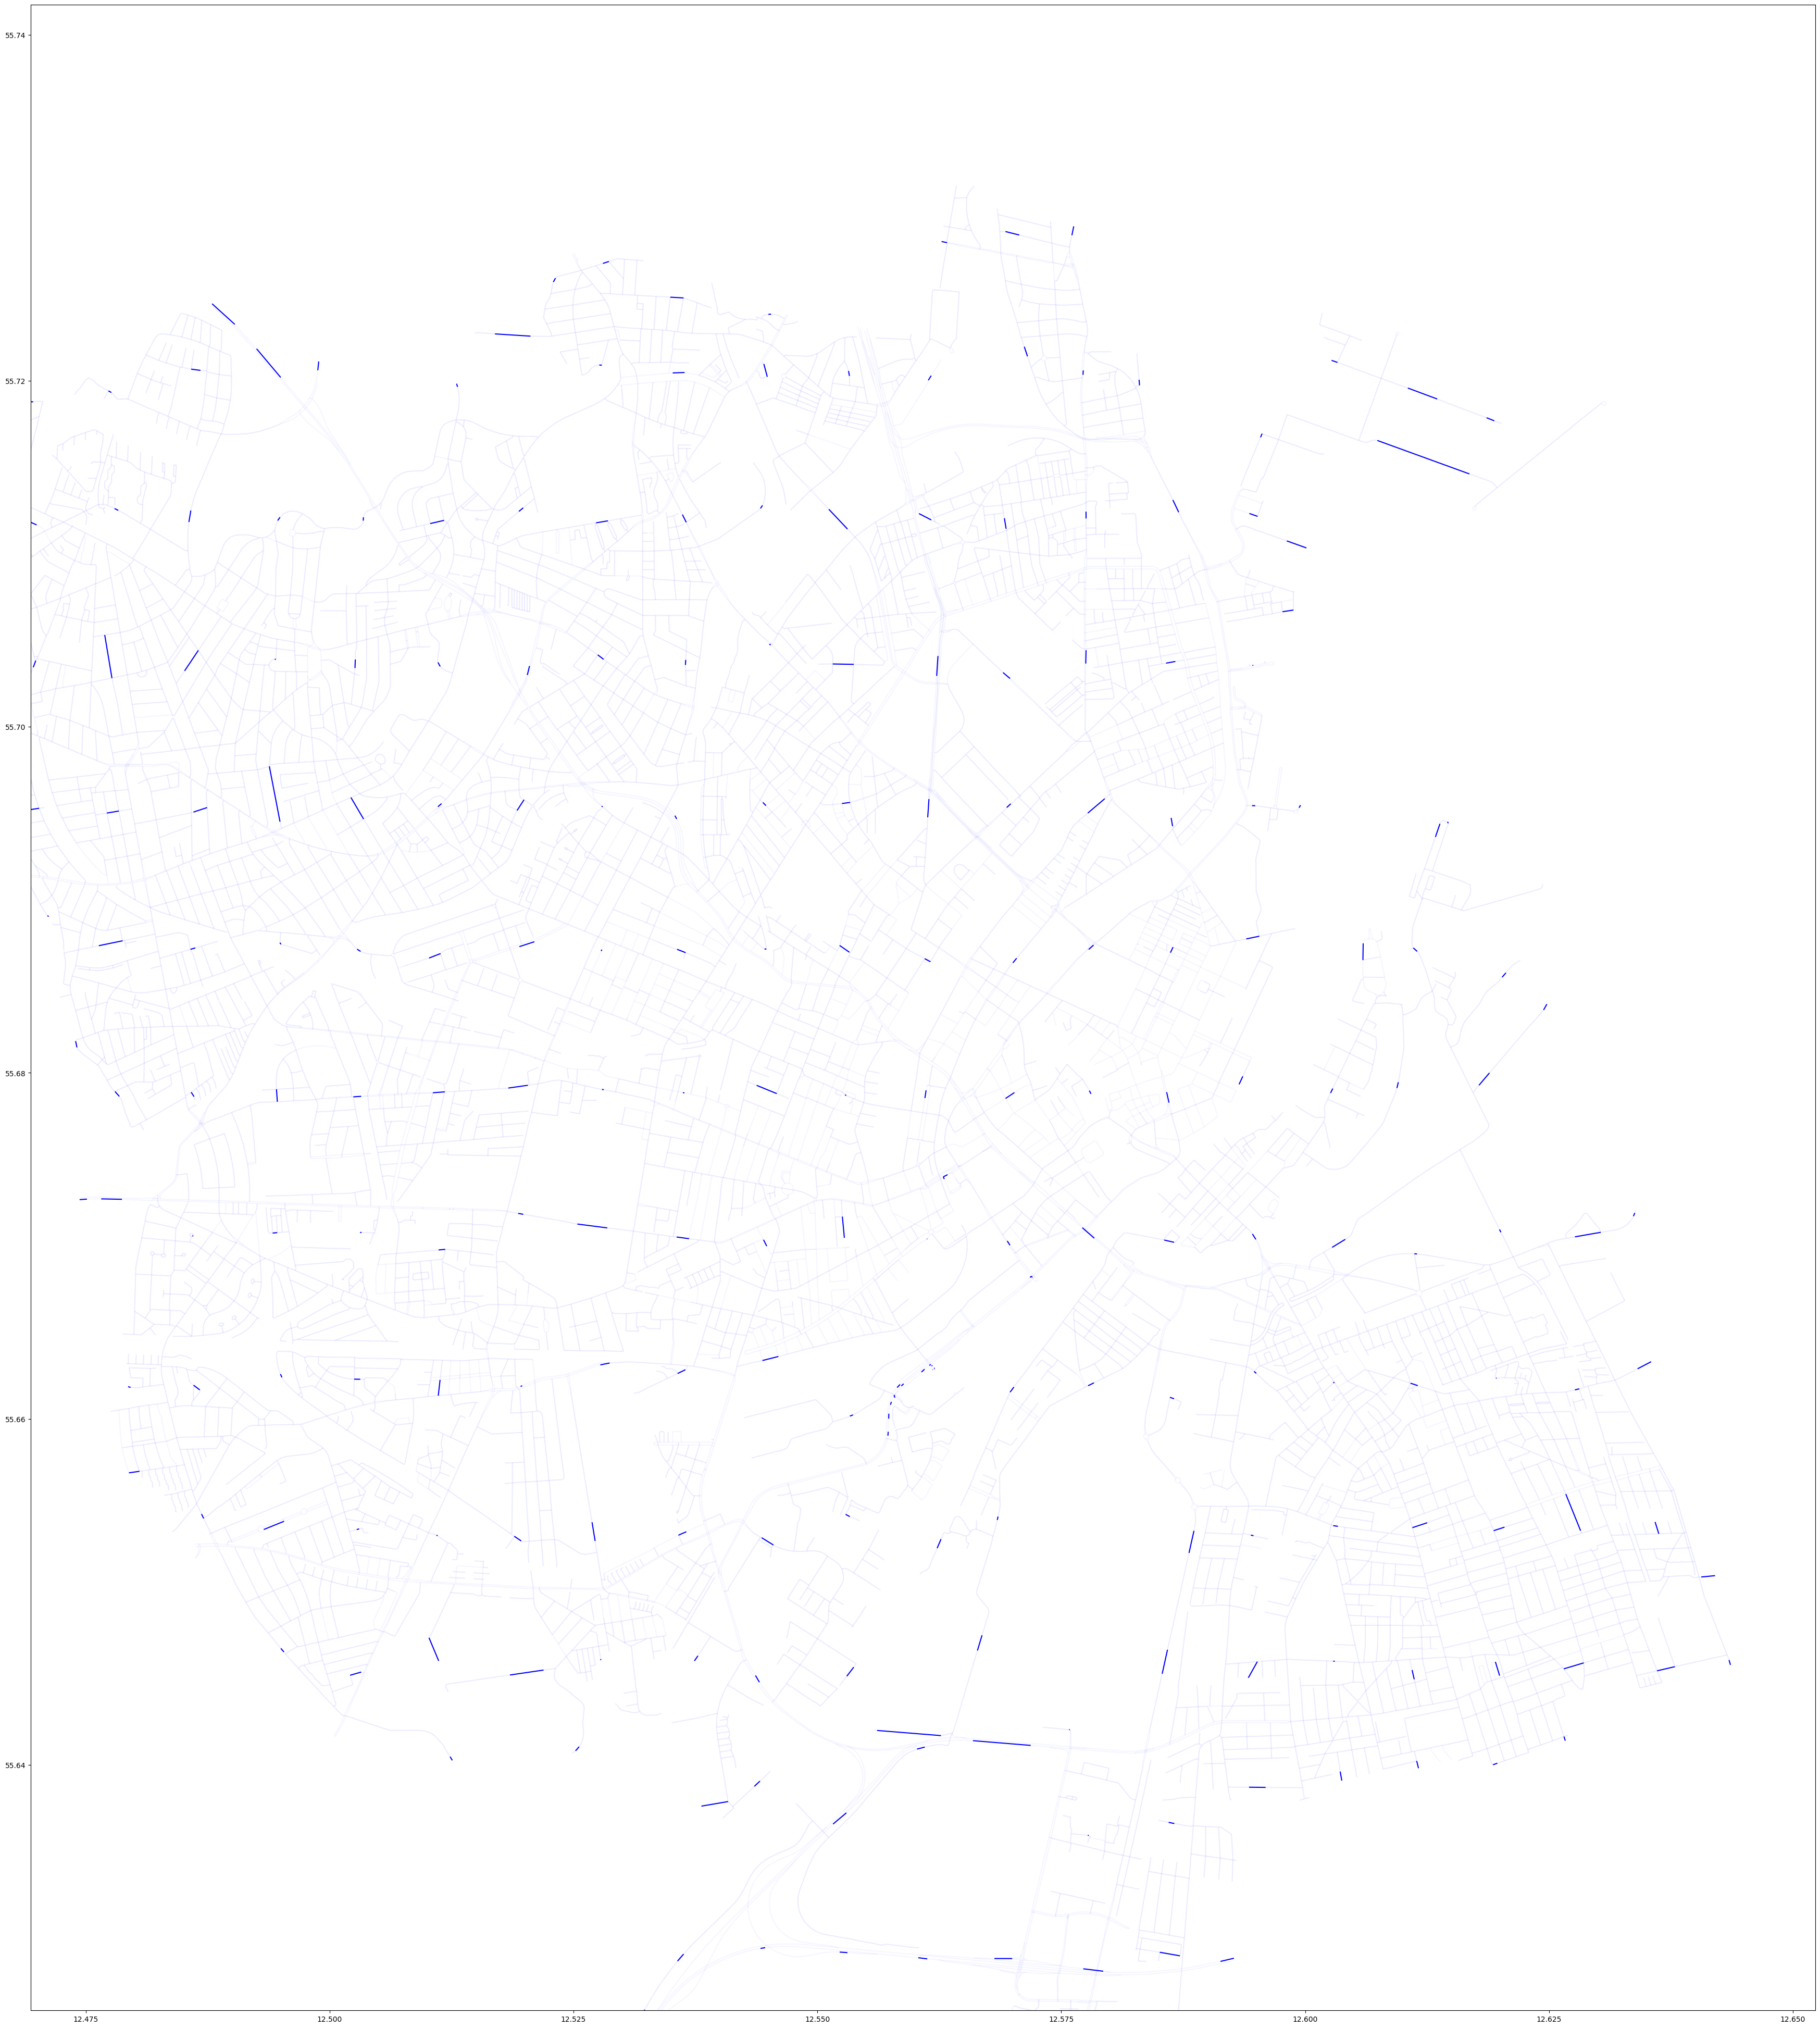

In [127]:
lanes = ox.graph_to_gdfs(G_carall, nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (pop_len_attr_dict[k]) == dd else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

In [124]:
ox_to_csv(G_carall, PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

ox_to_csv(ox.simplify_graph(G_carall), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

ox.save_graphml(G_carall, "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict_pop_den_attr.pkl', 'wb') as f:
    pickle.dump(pop_len_attr_dict, f)

copenhagen: Successfully wrote graph carall
copenhagen: Successfully wrote graph carall_simplified


In [ ]:
Audio(sound_file, autoplay=True)